In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [2]:
data = pd.read_csv('../../data/microchip_tests.txt', header=None, names = ('test1', 'test2', 'released'))

In [3]:
data

,test1,test2,released
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
...,...,...,...
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0


In [4]:
x = data.iloc[:,:2].values
y = data.iloc[:,2].values

In [5]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

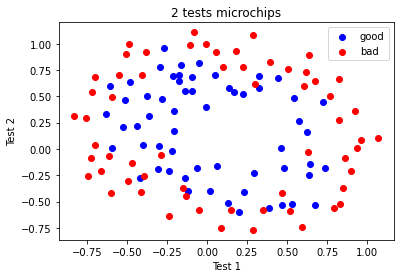

In [6]:
plt.scatter(x[y == 1, 0], x[y == 1, 1], c='blue', label='good')
plt.scatter(x[y == 0, 0], x[y == 0, 1], c='red', label='bad')
plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.title('2 tests microchips')
plt.legend();

In [7]:
def plot_boundary(clf, x, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
    y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step), 
                         np.arange(y_min, y_max, grid_step))
    
    z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    z = z.reshape(xx.shape)
    plt.contour(xx, yy, z, cmap=plt.cm.Paired)

In [8]:
poly = PolynomialFeatures(degree=7)
x_poly = poly.fit_transform(x)

In [9]:
x_poly.shape

(118, 36)

Доля правильных ответов классификатора на обучающей выборке: 0.831


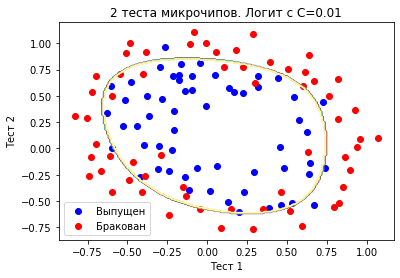

In [10]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(x_poly, y)

plot_boundary(logit, x, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(x[y == 1, 0], x[y == 1, 1], c='blue', label='Выпущен')
plt.scatter(x[y == 0, 0], x[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", round(logit.score(x_poly, y), 3))

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(x_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

In [43]:
logit_searcher.C_

array([5.43839743])

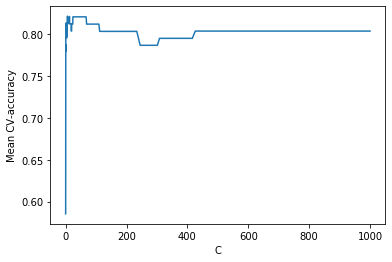

In [44]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');